## Определение перспективного тарифа телекомпании

### Описание проекта

У компании есть два тарифных планах "Смарт" и "Ультра", необходимо определить какой тариф приносит больше денег по выборке 500 клиентов.
  
| |«Смарт»|«Ультра»|
|--|--|--|
|Ежемесячная оплата|550|1950|
|Включено:|||
|Минут разговора|500|3000|
|Сообщений|50|1000|
|Гб трафика|15|30|
|Стоимость свыше:|||
|Минут разговора|3|1|
|Сообщений|3|1|
|Гб трафика|200|150|

Проверить 2 гипотезы:  
- Средняя выручка тарифов «Ультра» и «Смарт» различаются 
- Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

### Знакомство с данными и придение к нужным типам данных

In [100]:
import pandas as pd
import matplotlib
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
matplotlib.style.use('seaborn-pastel')
pd.options.display.float_format ='{:,.3f}'.format

In [101]:
try:
    df_users = pd.read_csv('users.csv', parse_dates=['churn_date', 'reg_date'])
    df_calls = pd.read_csv('calls.csv', parse_dates=['call_date'])
    df_messages = pd.read_csv('messages.csv', parse_dates=['message_date'])
    df_internet = pd.read_csv('internet.csv', parse_dates=['session_date'])
    df_tariffs = pd.read_csv('tariffs.csv')
except:
    df_users = pd.read_csv('/datasets/users.csv', parse_dates=['churn_date', 'reg_date'])
    df_calls = pd.read_csv('/datasets/calls.csv', parse_dates=['call_date'])
    df_messages = pd.read_csv('/datasets/messages.csv', parse_dates=['message_date'])
    df_internet = pd.read_csv('/datasets/internet.csv', parse_dates=['session_date'])
    df_tariffs = pd.read_csv('/datasets/tariffs.csv')

In [102]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   age         500 non-null    int64         
 2   churn_date  38 non-null     datetime64[ns]
 3   city        500 non-null    object        
 4   first_name  500 non-null    object        
 5   last_name   500 non-null    object        
 6   reg_date    500 non-null    datetime64[ns]
 7   tariff      500 non-null    object        
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


In [103]:
df_users[df_users.duplicated(subset=['last_name', 'first_name'])]

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff


In [104]:
df_users['tariff'].value_counts()

smart    351
ultra    149
Name: tariff, dtype: int64

`df_users` - дубликатов нет, пропущенные значения только в дате прекращения пользования тарифом(но согласно документации, данный тариф действующий). Все данные в правильных форматах.

In [105]:
df_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         202607 non-null  object        
 1   call_date  202607 non-null  datetime64[ns]
 2   duration   202607 non-null  float64       
 3   user_id    202607 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 6.2+ MB


In [106]:
df_calls[df_calls.duplicated(subset='id')]

,id,call_date,duration,user_id


`df_calls` - необходимо поправить duration(длительность звонка в минутах), т.к. в описании тарифа должно быть округление до целого. соответственно привести к int. еще конечно в идеале id хранить в int, но не уверен что стоит сейчас это делать.

In [107]:
df_calls.head(5)

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.000,1000
1,1000_1,2018-08-17,0.000,1000
2,1000_2,2018-06-11,2.850,1000
3,1000_3,2018-09-21,13.800,1000
4,1000_4,2018-12-15,5.180,1000


In [108]:
df_calls['duration'] = np.ceil(df_calls['duration']).astype(int)
df_calls.head(5)

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0,1000
1,1000_1,2018-08-17,0,1000
2,1000_2,2018-06-11,3,1000
3,1000_3,2018-09-21,14,1000
4,1000_4,2018-12-15,6,1000


In [109]:
df_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         202607 non-null  object        
 1   call_date  202607 non-null  datetime64[ns]
 2   duration   202607 non-null  int32         
 3   user_id    202607 non-null  int64         
dtypes: datetime64[ns](1), int32(1), int64(1), object(1)
memory usage: 5.4+ MB


In [110]:
df_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            123036 non-null  object        
 1   message_date  123036 non-null  datetime64[ns]
 2   user_id       123036 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.8+ MB


`df_messages` - Проблем не обнаружено, вроде все ок и все в правильном типе. Разве что можно поменять id на int

In [111]:
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Unnamed: 0    149396 non-null  int64         
 1   id            149396 non-null  object        
 2   mb_used       149396 non-null  float64       
 3   session_date  149396 non-null  datetime64[ns]
 4   user_id       149396 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 5.7+ MB


In [112]:
df_internet.head(5)

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.950,2018-11-25,1000
1,1,1000_1,"1,052.810",2018-09-07,1000
2,2,1000_2,"1,197.260",2018-06-25,1000
3,3,1000_3,550.270,2018-08-22,1000
4,4,1000_4,302.560,2018-09-24,1000


`df_internet` : Затисалась странная колонка, которую стоит удалить. мб надо будет перевести в гб, после того сделается сводная таблица

In [113]:
df_internet.drop(columns='Unnamed: 0', inplace=True)

In [114]:
df_tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


In [115]:
df_tariffs.head(5)

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


`df_tariffs` - все ок.

**Общий вывод**:  
В целом данные хорошие, пропусков нет, дубликатов нет, возможно появяться скрытые проблемы после того как начну группировать/ проводить аналитику

### Проверка на ошибки

<AxesSubplot:>

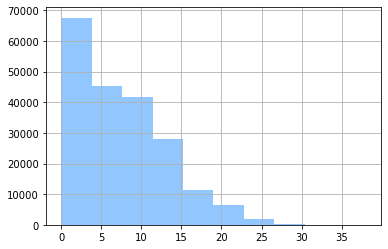

In [116]:
df_calls['duration'].hist()

In [117]:
df_calls.describe()

,duration,user_id
count,"202,607.000","202,607.000"
mean,7.158,"1,253.941"
std,5.959,144.723
min,0.000,"1,000.000"
25%,2.000,"1,126.000"
50%,6.000,"1,260.000"
75%,11.000,"1,379.000"
max,38.000,"1,499.000"


In [118]:
df_internet['mb_used'].describe()

count   149,396.000
mean        370.192
std         278.301
min           0.000
25%         138.188
50%         348.015
75%         559.553
max       1,724.830
Name: mb_used, dtype: float64

In [119]:
df_internet['mb_used'].describe()

count   149,396.000
mean        370.192
std         278.301
min           0.000
25%         138.188
50%         348.015
75%         559.553
max       1,724.830
Name: mb_used, dtype: float64

### Добавление колонок и создание сводных таблиц

In [120]:
# Проверка что все действия за 2018год и не вписалось ничего лишнего
df_calls['call_date'].describe(datetime_is_numeric=True)
df_internet['session_date'].describe(datetime_is_numeric=True)
df_messages['message_date'].describe(datetime_is_numeric=True)

count                           123036
mean     2018-09-04 15:28:42.227640576
min                2018-01-02 00:00:00
25%                2018-07-09 00:00:00
50%                2018-09-20 00:00:00
75%                2018-11-14 00:00:00
max                2018-12-31 00:00:00
Name: message_date, dtype: object

In [121]:
df_calls['call_month'] = df_calls['call_date'].dt.month
df_internet['internet_month'] = df_internet['session_date'].dt.month
df_messages['message_month'] = df_messages['message_date'].dt.month
df_internet.columns

Index(['id', 'mb_used', 'session_date', 'user_id', 'internet_month'], dtype='object')

In [122]:
df_pivot_calls = df_calls.pivot_table(
    values=['duration'], index=['user_id', 'call_month'], aggfunc=['sum']).reset_index()
df_pivot_calls.columns = ['user_id', 'month', 'sum_duration']
df_pivot_internet = df_internet.pivot_table(
    values=['mb_used'], index=['user_id','internet_month'], aggfunc=['sum']).reset_index()
df_pivot_internet.columns = ['user_id','month', 'mb_used']

Сразу переведем мегабайты в гигабайты, которые требуются для расчета стоитмости

In [123]:
df_pivot_internet['gb_used'] = np.ceil(df_pivot_internet['mb_used'] / 1024).astype(int)
df_pivot_internet.drop(columns=['mb_used'], inplace=True)
df_messages.columns
df_pivot_messages = df_messages.pivot_table(
    values=['id'], index=['user_id', 'message_month'], aggfunc=['count']
).reset_index()
df_pivot_messages.columns = ['user_id', 'month', 'count_message']
df_users['reg_date'].describe(datetime_is_numeric=True)

count                              500
mean     2018-06-30 18:57:35.999999744
min                2018-01-01 00:00:00
25%                2018-04-07 12:00:00
50%                2018-07-02 12:00:00
75%                2018-09-29 00:00:00
max                2018-12-31 00:00:00
Name: reg_date, dtype: object

Создание основной сводной таблицы

In [124]:
df_users['reg_month'] = df_users['reg_date'].dt.month
df_users['unreg_month'] = df_users['churn_date'].dt.month

In [125]:
df_users.columns

Index(['user_id', 'age', 'churn_date', 'city', 'first_name', 'last_name',
       'reg_date', 'tariff', 'reg_month', 'unreg_month'],
      dtype='object')

In [126]:
columns_name = [*list(df_users.columns), 'month']
df_main = pd.DataFrame(columns=columns_name)
def app_users(row: pd.Series):
    global df_main
    if pd.isna(row['unreg_month']):
        max_month = 13
    else:
        max_month = row['unreg_month']
    for i in range(row['reg_month'] + 1, int(max_month)):
        row['month'] = i
        df_main = pd.concat([df_main, row.to_frame().T])
    return row

df_users.apply(app_users, axis=1)


,age,churn_date,city,first_name,last_name,month,reg_date,reg_month,tariff,unreg_month,user_id
0,52,NaT,Краснодар,Рафаил,Верещагин,12.000,2018-05-25,5,ultra,NaN,1000
1,41,NaT,Москва,Иван,Ежов,12.000,2018-11-01,11,smart,NaN,1001
2,59,NaT,Стерлитамак,Евгений,Абрамович,12.000,2018-06-17,6,smart,NaN,1002
3,23,NaT,Москва,Белла,Белякова,12.000,2018-08-17,8,ultra,NaN,1003
4,68,NaT,Новокузнецк,Татьяна,Авдеенко,12.000,2018-05-14,5,ultra,NaN,1004
...,...,...,...,...,...,...,...,...,...,...,...
495,65,NaT,Иркутск,Авксентий,Фокин,12.000,2018-08-28,8,ultra,NaN,1495
496,36,NaT,Вологда,Трифон,Блохин,12.000,2018-01-27,1,smart,NaN,1496
497,32,NaT,Челябинск,Каролина,Агеева,12.000,2018-10-09,10,smart,NaN,1497
498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,9.000,2018-07-19,7,smart,10.000,1498


In [127]:
df_main = df_main.merge(df_pivot_calls, how='left', on=['user_id', 'month'])
df_main = df_main.merge(df_pivot_internet, how='left', on=['user_id', 'month'])
df_main = df_main.merge(df_pivot_messages, how='left', on=['user_id', 'month'])

#### Проверка что ничего не потеряли

In [128]:
df_pivot_calls_check = df_pivot_calls.merge(df_users[['user_id', 'reg_month', 'unreg_month']], how='inner', on=['user_id'])
len(df_pivot_calls) == len(df_pivot_calls_check)

True

In [129]:
len(df_pivot_calls_check.query('month != reg_month and month !=unreg_month')) # Длина актуальной выборки

2647

In [130]:
# Те кто не попал в таблицу, потому что в сводной по ним не было данных
len(df_main[df_main['sum_duration'].isna()])

33

In [131]:
# Люди которые внеслись и совершали вызовы
len(df_main[df_main['sum_duration'].notnull()])

2647

In [132]:
len(df_main[df_main['sum_duration'].isna() & 
        df_main['gb_used'].isna() &
        df_main['count_message'].isna()
        ])

0

Может и чуток усложнил, но таким образом точно все попали, допустим, если бы человек вообще не пользовался услугами, то тогда бы объединяя таблицы, мы бы его не увидели.
Поэтому сначала сделал болванку со всеми месяцами, а потом туда подгружал данные. чтоб данные были за полный месяц использования, я отбрасывал звонки / интернет / сообщения которые использовались в месяца совпадающие с регистрацией или когда человек отказался от симки.  
Проверял на звонках, но везде алгоритм был один, поэтому не вижу смысл сверять с мб и смс


Получили сводную таблицу, только с полными месяцами использования. Есть некоторые месяцы с пропусками, скорее всего связано с тем, что человек не пользовался услугами связи в эти месяцы. Заполним нулями, чтоб пропуски отображались в статистике

<AxesSubplot:>

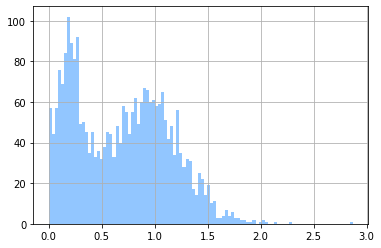

In [133]:
columns_for_change_none = ['sum_duration', 'gb_used', 'count_message']
for column in columns_for_change_none:
    df_main[column].fillna(value=0, inplace=True)
df_main.rename(columns={'tariff' : 'tariff_name'}, inplace=True)
df_main = df_main.merge(df_tariffs, how='outer', on='tariff_name')
# Какой % использован из выделенного тарифа
df_main['per_minutes'] = df_main['sum_duration'] / df_main['minutes_included']
df_main['per_minutes'].hist(bins=100)

Наткнулся на проблему: что есть включенные мегабайты, а цена за гигабайты... поэтому переводим в гигабайты как делали ранее

In [134]:
df_main['gb_included'] = (df_main['mb_per_month_included']/1024).astype(int)
df_main.drop(columns='mb_per_month_included', inplace=True)

In [135]:
def check_money(include, spent, price):
    def check_money_inside(row):
        nonlocal include, spent, price
        if row[spent] <= row[include]:
            return 0 
        elif row[spent] > row[include]:
            return (row[spent] - row[include])*row[price] 
    return check_money_inside
    
minutes = check_money('minutes_included', 'sum_duration', 'rub_per_minute')
internet = check_money('gb_included', 'gb_used', 'rub_per_gb')
messages = check_money('messages_included', 'count_message', 'rub_per_message')

In [136]:
def check_money(include, spent, price):
    '''Функция для подсчета затраченного сверх тарифа(минут/гб/смс)'''
    def check_money_inside(row):
        nonlocal include, spent, price
        return 0 if row[spent] <= row[include] else (row[spent] - row[include])*row[price]
    return check_money_inside
    
minutes = check_money('minutes_included', 'sum_duration', 'rub_per_minute')
internet = check_money('gb_included', 'gb_used', 'rub_per_gb')
messages = check_money('messages_included', 'count_message', 'rub_per_message')

In [137]:
df_main['total_rub_duration'] = df_main.apply(minutes, axis=1)
df_main['total_rub_internet'] = df_main.apply(internet, axis=1)
df_main['total_rub_messages'] = df_main.apply(messages, axis=1)
df_main['total_rub_service'] = df_main['total_rub_duration'] + \
    df_main['total_rub_internet'] + df_main['total_rub_messages'] 
df_main['total_rub'] = df_main['total_rub_service'] + \
    df_main['rub_monthly_fee']

In [138]:
df_main['service_bool'] = df_main.apply(
    lambda row: 0 if row['total_rub'] == row['rub_monthly_fee'] else 1, axis=1
)

In [139]:
df_ultra = df_main.query('tariff_name == "ultra"')
df_smart = df_main.query('tariff_name == "smart"')

Данные подготовил, далее идет аналитика, гипотезы и т.п., предварительно удаляю все левые переменные, чтоб глаза не мазолили

In [140]:
del df_calls, df_internet, df_users, df_tariffs, df_messages
del df_pivot_calls, df_pivot_internet, df_pivot_messages, df_pivot_calls_check
del column, columns_for_change_none

### Ответы на вопросы и анализ

#### Функция отрисовки

In [141]:
def show_hist(name_column, text, hist_range, ylim=True):
    '''Функция для отрисовки графика и вывода основных значений

    Args:
        name_column (str): колонка df по которой строить
        text (str): Название таблицы
        hist_range (tuple): Диапазон для которой строить гистограмму плотностей
        ylim (list): Высота по y для абсолютных значений
    '''
    ultra_list = df_ultra[name_column]
    ultra_std = np.std(ultra_list)  # Стандартное отклонение
    ultra_var = np.var(ultra_list)  # Дисперсия
    ultra_mean = ultra_list.mean()  # Мат. ожидание

    smart_list = df_smart[name_column]
    smart_std = np.std(smart_list)
    smart_var = np.var(smart_list)
    smart_mean = smart_list.mean()

    fig = plt.figure(figsize=(14,5))
    x_axis = np.arange(*hist_range)
    ax1 = fig.add_subplot(121)
    ax1.plot(x_axis, st.norm.pdf(x_axis, smart_mean, smart_std), color='red', label='Smart')
    ax1.plot(x_axis, st.norm.pdf(x_axis, ultra_mean, ultra_std), color='blue', label='Ultra')
    plt.ylabel('Плотность распределения')
    plt.xlabel('Значения')
    plt.title(text)
    plt.legend()
    ax2 = fig.add_subplot(122)
    df_smart_group = df_smart.groupby(name_column)['user_id'].count()
    df_ultra_group = df_ultra.groupby(name_column)['user_id'].count()
    ax2.plot(df_smart_group, color='red', label='Smart')
    ax2.plot(df_ultra_group, color='blue', label='Ultra')
    plt.ylim(ylim)
    plt.xlabel('Значения')
    plt.title('График абсолютных значений')
    plt.legend()
    plt.show
    print(f'STD (Ultra) | STD (Smart) : {ultra_std:.2f} | {smart_std:.2f}')
    print(f'VAR (Ultra) | VAR (Smart) : {ultra_var:.2f} | {smart_var:.2f}')
    print(f'MEAN (Ultra)| MEAN (Smart): {ultra_mean:.2f} | {smart_mean:.2f}')


#### Использование интернета

STD (Ultra) | STD (Smart) : 9.25 | 4.80
VAR (Ultra) | VAR (Smart) : 85.50 | 23.01
MEAN (Ultra)| MEAN (Smart): 21.18 | 17.64


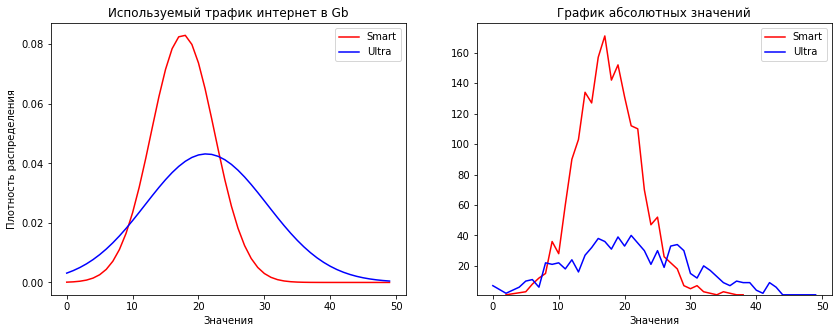

In [142]:
show_hist('gb_used', 'Используемый трафик интернет в Gb', (0,50,1))

In [143]:
per_smart = len(df_smart.query('gb_used >= gb_included')) / len(df_smart)
per_ultra = len(df_ultra.query('gb_used >= gb_included')) / len(df_ultra)
print(f'Пользователи тарифа "Смарт", использующие больше включенного трафика: {per_smart:.2%}')
print(f'Пользователи тарифа "Ультра", использующие больше включенного трафика: {per_ultra:.2%}')

Пользователи тарифа "Смарт", использующие больше включенного трафика: 73.61%
Пользователи тарифа "Ультра", использующие больше включенного трафика: 17.74%


По гистограмме распределения видно
- Люди использующие тариф смарт стараются попадать в тариф и следят за трафиком, но далеко не всегда выходит
- Пользователи тарифа "Ультра" какие то пофигисты и всего 1/5 использует сверх трафика
- Разброс используемоего трафика в тарифе ультра гораздо больше, соответственно и дисперсия больше
- Интересно, что среднее значение у тарифов отличается всего на 3гб по выборке... но это толком ни о чем не говорит

#### Использование мобильной связи

STD (Ultra) | STD (Smart) : 307.06 | 176.27
VAR (Ultra) | VAR (Smart) : 94283.00 | 31070.12
MEAN (Ultra)| MEAN (Smart): 572.93 | 453.00


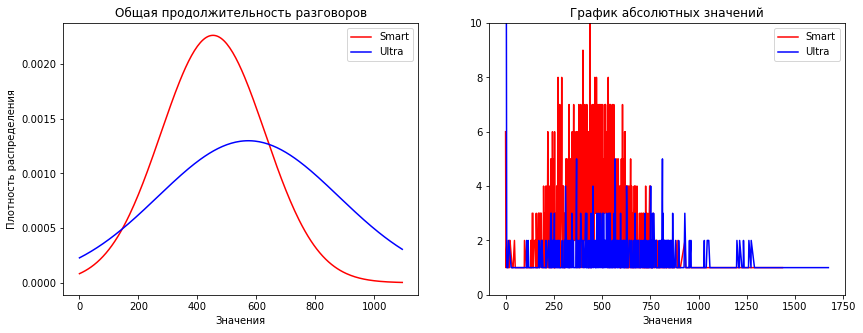

In [144]:
show_hist('sum_duration', 'Общая продолжительность разговоров', (0, 1100, 5), ylim=[0,10])

In [145]:
per_smart = len(df_smart.query('sum_duration >= minutes_included')) / len(df_smart)
per_ultra = len(df_ultra.query('sum_duration >= minutes_included')) / len(df_ultra)
print(f'Пользователи тарифа "Смарт", выговаривающие больше включенных минут: {per_smart:.2%}')
print(f'Пользователи тарифа "Ультра", выговаривающие больше включенных минут: {per_ultra:.2%}')

Пользователи тарифа "Смарт", выговаривающие больше включенных минут: 39.26%
Пользователи тарифа "Ультра", выговаривающие больше включенных минут: 0.00%


Есть некоторая схожесть с ситуацией с интернетом:
- Дисперсия длительности звонков пользователей тарифа "Ультра" ну и как следствие график растянут. возможно также связано с тем что выборка меньше по пользователям Ультра
- Пользователи тарифа "Ультра" реже выходят за минуты включенные в тариф(В выборке вообще нет таких людей)  
- Разница среднего у пользователей не очень большая: менее 100минут в месяц

#### Смс

In [146]:
df_smart.columns

Index(['user_id', 'age', 'churn_date', 'city', 'first_name', 'last_name',
       'reg_date', 'tariff_name', 'reg_month', 'unreg_month', 'month',
       'sum_duration', 'gb_used', 'count_message', 'messages_included',
       'minutes_included', 'rub_monthly_fee', 'rub_per_gb', 'rub_per_message',
       'rub_per_minute', 'per_minutes', 'gb_included', 'total_rub_duration',
       'total_rub_internet', 'total_rub_messages', 'total_rub_service',
       'total_rub', 'service_bool'],
      dtype='object')

STD (Ultra) | STD (Smart) : 48.92 | 28.72
VAR (Ultra) | VAR (Smart) : 2393.33 | 825.01
MEAN (Ultra)| MEAN (Smart): 53.02 | 36.19


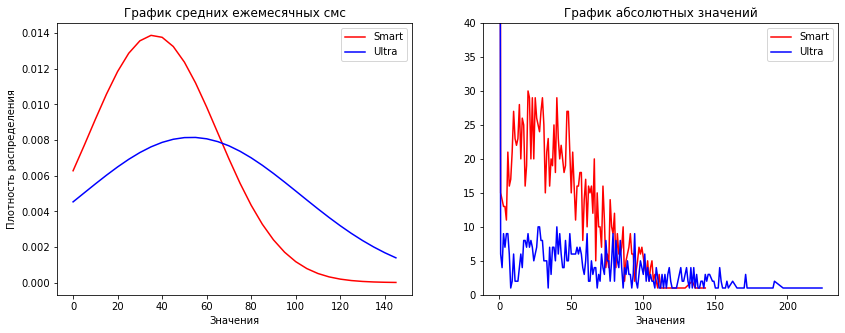

In [147]:
show_hist('count_message', 'График средних ежемесячных смс', (0, 150, 5), ylim=[0,40])

In [148]:
per_smart = len(df_smart.query('count_message >= messages_included')) / len(df_smart)
per_ultra = len(df_ultra.query('count_message >= messages_included')) / len(df_ultra)
print(f'Пользователи тарифа "Смарт", кто шлёт смс больше положенного: {per_smart:.2%}')
print(f'Пользователи тарифа "Ультра", кто шлёт смс больше положенного: {per_ultra:.2%}')

Пользователи тарифа "Смарт", кто шлёт смс больше положенного: 29.35%
Пользователи тарифа "Ультра", кто шлёт смс больше положенного: 0.00%


In [149]:
df_main['count_message'].describe()

count   2,680.000
mean       41.359
std        36.978
min         0.000
25%        12.000
50%        34.000
75%        61.000
max       224.000
Name: count_message, dtype: float64

Удивлен, довольно много пользователей сих пор пользуются смс. в средним 1шт. в ~~месяц~~ день. Распределения использования смс напоминает распределения использования мобильной связи и интернет трафика.  
Единственно людей которые посылают смс больше чем включено в тариф меньше, по сравнению с людьми превыщаюшими тариф интернета и телефона

In [150]:
df_main.columns

Index(['user_id', 'age', 'churn_date', 'city', 'first_name', 'last_name',
       'reg_date', 'tariff_name', 'reg_month', 'unreg_month', 'month',
       'sum_duration', 'gb_used', 'count_message', 'messages_included',
       'minutes_included', 'rub_monthly_fee', 'rub_per_gb', 'rub_per_message',
       'rub_per_minute', 'per_minutes', 'gb_included', 'total_rub_duration',
       'total_rub_internet', 'total_rub_messages', 'total_rub_service',
       'total_rub', 'service_bool'],
      dtype='object')

In [151]:
len(df_main.query('sum_duration == 0 and count_message == 0 and gb_used == 0'))

0

#### Сравнение выручки

In [152]:
per_difference_1950 = len(df_smart.query('total_rub >= 1950'))/len(df_smart)

In [153]:
print(f'Только {per_difference_1950:.2%} пользователей тарифа "Смарт" тратят больше чем пользователи тарифа "Ультра"')

Только 24.72% пользователей тарифа "Смарт" тратят больше чем пользователи тарифа "Ультра"


STD (Ultra) | STD (Smart) : 406.55 | 829.48
VAR (Ultra) | VAR (Smart) : 165281.98 | 688042.94
MEAN (Ultra)| MEAN (Smart): 2091.98 | 1407.51


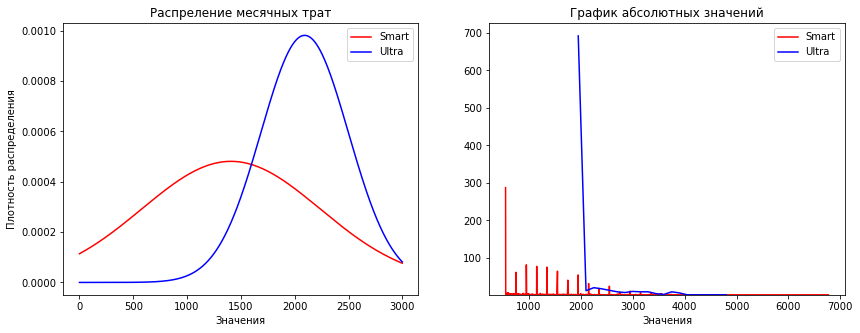

In [154]:
show_hist('total_rub','Распреление месячных трат', (0,3000))

<function matplotlib.pyplot.show(close=None, block=None)>

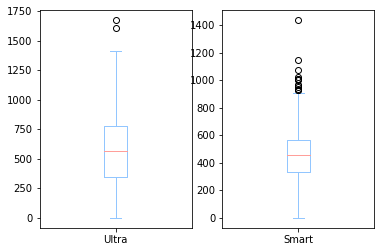

In [155]:
plt.subplot(121)
df_ultra['sum_duration'].plot(kind='box', label='Ultra')
plt.subplot(122)
df_smart['sum_duration'].plot(kind='box', label='Smart')

plt.show

Общий вывод:
- 1.5% пользователей не пользуются связью вообще.(ну точнее в опреленные месяцы)
- Выборка для пользователей тарифа "Ультра" имеет большую дисперсию и разброс данных(Это видно как и по гистограммам распределения, так и boxplot) Можно говорить о том что данных маловато
- Пользователи тарифа "Ультра" реже используют услуги сверх нормы
- Важно отметить, что основная часть докупаемых услуг - объем интернет трафика, реже: мобильная связь и смс. Компании стоит подумать о тарифе с увеличенным кол-вом трафика
- На самом деле по графика ежемесячных платежей видно, что средняя выручка c пользовтелей разная... но по ТЗ надо проверить гипотезы, поэтому переходим к сл. части задания

### Формулирование и проверка гипотез

#### Гипотеза 1. Средняя выручка

$H_0$ (Нулевая гипотеза) - Выручки одинаковые
$H_1$ (Альтернативная двухстороняя гипотеза) - Выручка отличается

In [156]:
st.ttest_ind(df_smart['total_rub'], df_ultra['total_rub'], equal_var=True).pvalue

8.438837083020635e-103

e-111 .... тут никакой альфа не поможет. значения очень отличаются. гипотезу "Выручки одинаковые" - отвергаем 

#### Гипотеза 2. Региональная выручка

$H_0$ (Нулевая гипотеза) - Средняя выручка пользователей из Москвы ~~отличается~~ такая же как "средняя по больнице"  
$H_1$ (Альтернативная двухстороняя гипотеза) - Средняя выручка пользователей ~~всех регионов одинаковая~~ различается от региона
  
Тут стоит наверно отметить, что сравнивать всех пользователей не очень корректно, поэтому правильно выбрать пользователей тарифа Смарт и их сравнить и пользователей тарифа Ультра их сравнить

In [157]:
df_smart['city'].value_counts()

Москва             313
Санкт-Петербург    178
Ульяновск           71
Казань              61
Уфа                 59
                  ... 
Тула                 4
Нижний Тагил         4
Владикавказ          4
Тверь                4
Оренбург             3
Name: city, Length: 70, dtype: int64

In [158]:
df_smart_moscow = df_smart.query('city == "Москва"')
df_smart_another_region = df_smart.query('city != "Москва"')
df_ultra_moscow = df_ultra.query('city == "Москва"')
df_ultra_another_region = df_ultra.query('city != "Москва"')

In [159]:
def ttest(df_1, df_2, alpha):
    result = st.ttest_ind(df_1['total_rub'], df_2['total_rub']).pvalue
    if  result < alpha:
        print(f'Гипотезу отвергаем, pvalue = {result:.2}')
    else:
        print(f'Гипотезу не отвергаем, pvalue = {result:.2}')

In [160]:
alpha = .05
ttest(df_smart_moscow, df_smart_another_region, alpha)
ttest(df_ultra_moscow, df_ultra_another_region, alpha)

Гипотезу не отвергаем, pvalue = 0.39
Гипотезу не отвергаем, pvalue = 0.92


<function matplotlib.pyplot.show(close=None, block=None)>

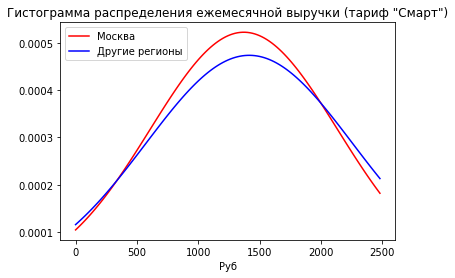

In [161]:
moscow_mean = df_smart_moscow['total_rub'].mean()
moscow_std = np.std(df_smart_moscow['total_rub'])
another_region_mean = df_smart_another_region['total_rub'].mean()
another_region_std = np.std(df_smart_another_region['total_rub'])
x_axis = np.arange(0,2500,20)
plt.plot(x_axis, st.norm.pdf(x_axis, moscow_mean, moscow_std), color='red', label='Москва')
plt.plot(x_axis, st.norm.pdf(x_axis, another_region_mean, another_region_std), color='blue', label='Другие регионы')
plt.xlabel('Руб')
plt.title('Гистограмма распределения ежемесячной выручки (тариф "Смарт")')
plt.legend()
plt.show

### Общий вывод

**Проделано:**    
- Сделаны сводные таблицы, проверены гипотезы  
  
**Ответы на вопросы:**  
- По выборке мы не можем утверждать, что пользователи из Москвы тратят больше или меньше чем, пользователи из других регионов
- Средняя выручка тарифа "Ультра" больше выручки тарифа "Смарт", т.к. не смотря на то что люди выходят гораздо реже за пределы трафика, абонентская плата решает. Примерно четверть пользователей тарифа "Смарт" платят больше абоненской платы тарифа "Ультра"(1950руб)  
   
**Гипотезы**
- Гипотезу "Пользователи тарифа "Ультра" и "Смарт" имеют разную выручку" - **Не отвергаем**:
- Гипотезу "Выручка пользователей из Москвы отличается от выручки пользователей из др.регионов" - **Отвергаем**:

**Рекомендации:**
- Подумать о тарифе с большим трафиком(более половины пользователей "Смарт" выходит за лимит)